# Цель Блокнота

Решение задачи классификации в scikit-learn с помощью линейной модели - логистическая регрессия
* Применение `LabelEncoding` для изменения целевой переменной
* Обучение класса `LogisticRegression` и анализ атрибутов
* Анализ модели для разных данных
* Сохранение модели

# Import библиотек

In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего

import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn
from sklearn.preprocessing import LabelEncoder# Импортируем LabelEncoder от scikit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Набор данных


Набор данных представляет собой статистику признаков автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений

Каждый столбец в записи — это отдельный признак.

 Также среди признаков есть условный целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий признак).

# Загрузка данных

Загружаем наши данные из файла по прямой ссылке на git-hub

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/mpti_ml/main/data/cars_moldova_clean.csv', delimiter = ',')
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


Список числовых и категориальных данных

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

Предварительная обработка из [раннего блокнота](https://colab.research.google.com/drive/1es_OrShFiuaeOnlPjX2B1geHDM-XfofM?usp=sharing)

Из предварительной обработки исключена колонка `Transmission`, поскольку она является целевой меткой и будет обработана отдельно


In [ ]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

In [ ]:
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy

In [ ]:
num_pipe_distance = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('scaler', StandardScaler())
])

num_distance = ['Distance']

num_pipe_engine = Pipeline([
    ('scaler', StandardScaler())
])

num_engine = ['Engine_capacity(cm3)']

num_pipe_year = Pipeline([
    ('power', PowerTransformer())
])

num_year = ['Year']

num_pipe_price = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('power', PowerTransformer())
])



num_price = ['Price(euro)']


cat_pipe_style_fuel = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])

cat_style_fuel = ['Style', 'Fuel_type']

cat_pipe_make = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_make = ['Make']

cat_pipe_model = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.0001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_model = ['Model']

# Сделаем отдельно Pipeline с числовыми признаками
preprocessors_num = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
    ('num_price', num_pipe_price, num_price),
])

# и Pipeline со всеми признаками
preprocessors_all = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
    ('num_price', num_pipe_price, num_price),
    ('cat_style_fuel', cat_pipe_style_fuel, cat_style_fuel),
    ('cat_make', cat_pipe_make, cat_make),
    ('cat_model', cat_pipe_model, cat_model),
])

In [ ]:
# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns_num = np.hstack([num_distance,
                    num_engine,
                    num_year,
                        num_price ])

# Логистическая Регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression # Логистичекая регрессия от scikit-learn

from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# в исполнении scikit-learn

from sklearn.model_selection import StratifiedKFold # при кросс-валидации разбиваем данные в пропорции целевой метки
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import f1_score # f1-мера от Scikit-learn
from sklearn.metrics import classification_report # функция scikit-learn которая считает много метрик классификации
from sklearn.metrics import ConfusionMatrixDisplay # матрица ошибок


**Считываем данные, разбиваем на тестовую и тренировочную**

In [ ]:
# не забываем удалить целевую переменную "тип трансмиссии" из признаков
X,y = DF.drop(columns = ['Transmission']), DF['Transmission']

## Приводим целевые метки к 0 и 1

Для этого воспользуемся объектом `LabelEncoder()` из модуля `preprocessing`

Применение преобразований уже стандартное для нас

* Создаем объект
* обучаем методом `.fit()`
* Смотрим что получилось

In [ ]:
Label = LabelEncoder()
Label.fit(y) # задаем столбец, который хотим преобразовать
Label.classes_ # в аттрибуте .classes_ хранится информация "какой класс как шифруется"

array(['Automatic', 'Manual'], dtype=object)

т.е. `0` это 'Automatic', а `1` это 'Manual'

In [ ]:
target = Label.transform(y) # преобразуем и сохраняем в новую переменную

In [ ]:
target # здесь уже только 0 и 1

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
# разбиваем на тренировочную и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, target,
                                                    test_size=0.3,
                                                    random_state=42)

# Оценим модель с использованием только числовых данных

**Преобразуем данные**

In [ ]:
# Сначала обучаем на тренировочных данных
X_train_prep = preprocessors_num.fit_transform(X_train)
# потом на валидационной
X_val_prep = preprocessors_num.transform(X_val)

**Обучаем модель**



Стандартная уже для нас рутина

* Создаем объект класса
* "Обучаем" через `.fit`

In [ ]:
model = LogisticRegression(random_state = 42)

model.fit(X_train_prep, y_train);

## Подготовим несколько функций для анализа обученной модели

Эти фунции были рассмотрены [ранее](https://colab.research.google.com/drive/1QE2uUp4dEJegxEFJsJHz-ct_tTXxZNHJ?usp=sharing)

Небольшая разница связана с форматом хранения аттрибута `coef_`





**вытаскивание коэффициентов из модели**

In [ ]:
def get_coefs (model):
    """Берем веса как атрибуты обученной модели.
    Входные переменные:
    ===========
    model: обученная модель
    """
    B0=model.intercept_[0]
    B=model.coef_[0]
    return B0, B

**написание модели**

In [ ]:
def print_model (B0,B,features_names):
    """Написание уравнения модели.
    Входные переменные:
    ===========
    B0: смещение (независимый коэффициент)
    weights: веса признаков
    features_names: список названий признаков
    """
    line='{:.3f}'.format(B0)
    sign=['+','-']
    for p,(fn,b) in enumerate(zip(features_names,B)):
        line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

    print('Решение')
    print(line)

**визуализации весов в виде столбчатых диаграмм**

In [ ]:
def vis_weigths(weights,features_names = None, width = 1200, height = 600):
    """Отрисовка весов.
    Входные переменные:
    ===========
    weights: веса признаков
    features_names: список названий признаков
    """
    numbers = np.arange(0,len(weights))                 # создаем массив от 0 до количество весов-1
    if features_names:
        tick_labels = np.hstack(['B0',features_names])
    else:
        tick_labels = ['B'+str(num) for num in numbers] # создаем "названия" весов
    fig = go.Figure()
    fig.add_trace(go.Bar(x=numbers[weights<0], y=weights[weights<0],
                    marker_color='red',
                    name='отрицательные веса'))
    fig.add_trace(go.Bar(x=numbers[weights>=0], y=weights[weights>=0],
                    marker_color='blue',
                    name='положительные веса'
                    ))

    fig.update_layout(
                title="Веса модели",
                width=width,
                height=height,
                template = "plotly_dark",
                xaxis = dict(
                                         tickmode = 'array',
                                         tickvals = numbers,
                                         ticktext = tick_labels,
                                         )
                )

    fig.show()

### Напишем уравнение модели

In [ ]:
B0, B = get_coefs(model)
features_names = list(columns_num)
print_model(B0,B,features_names)

Решение
0.249+0.10*Distance-1.04*Engine_capacity(cm3)-0.61*Year-0.98*Price(euro)


### Визуализируем веса в виде столбчатых диаграмм

In [ ]:
Bs = np.hstack([B0,B])
vis_weigths(Bs,features_names)

## Оценка метрик

In [ ]:
def calculate_metric(model_pipe, X, y, metric = f1_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (f1 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model)

In [ ]:
print(f"f1 на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train):.4f}")
print(f"f1 на валидационной выборке: {calculate_metric(model, X_val_prep, y_val):.4f}")

f1 на тренировочной выборке: 0.8114
f1 на валидационной выборке: 0.8168


In [ ]:
print(classification_report(y_val, model.predict(X_val_prep), target_names=Label.classes_))

              precision    recall  f1-score   support

   Automatic       0.78      0.75      0.77      4383
      Manual       0.80      0.83      0.82      5363

    accuracy                           0.79      9746
   macro avg       0.79      0.79      0.79      9746
weighted avg       0.79      0.79      0.79      9746



## Кросс-валидация

In [ ]:
def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])

In [ ]:
scoring_clf = {'ACC': 'accuracy',
           'F1': 'f1_micro',
           'Precision': 'precision_weighted',
           'Recall': 'recall_macro'}

In [ ]:
cross_validation (X_train_prep, y_train,
                  model,
                  scoring_clf,
                  StratifiedKFold(n_splits=5, shuffle= True, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,0.140002,0.024120,0.786939,0.786939,0.786644,0.783080
1,0.036642,0.110627,0.793316,0.793316,0.793224,0.788884
2,0.077458,0.051483,0.795954,0.795954,0.795753,0.791989
3,0.069354,0.043308,0.789358,0.789358,0.789244,0.784853
4,0.077437,0.051144,0.781394,0.781394,0.781134,0.777119




test_ACC          0.789392
test_F1           0.789392
test_Precision    0.789200
test_Recall       0.785185
dtype: float64


## Матрица ошибок



Есть три варианта отображения
* нормированный (по строкам)

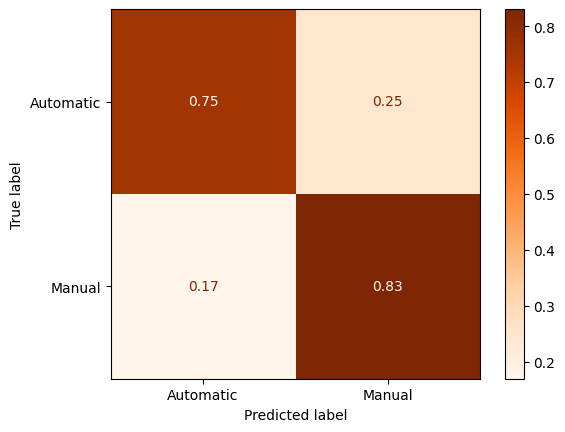

In [ ]:
ConfusionMatrixDisplay.from_estimator(
        model,
        X_val_prep,
        y_val,
        display_labels=Label.classes_,
         cmap=plt.cm.Oranges,
        normalize='true',
    );

* нормированный по всей матрице

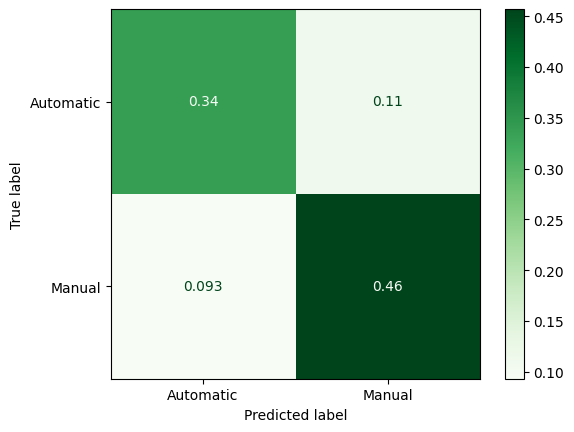

In [ ]:
ConfusionMatrixDisplay.from_estimator(
        model,
        X_val_prep,
        y_val,
        display_labels=Label.classes_,
         cmap=plt.cm.Greens,
        normalize='all',
    );

* не нормированный

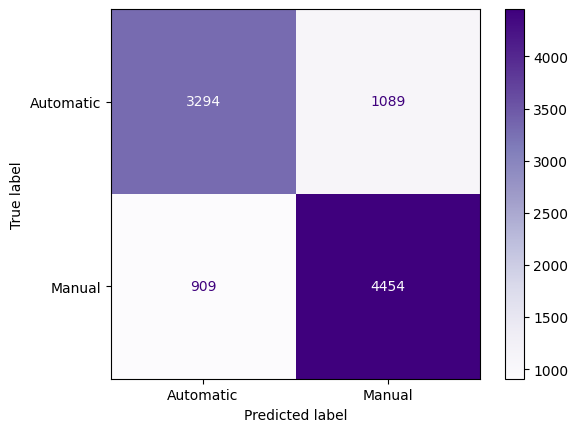

In [ ]:
ConfusionMatrixDisplay.from_estimator(
        model,
        X_val_prep,
        y_val,
        display_labels=Label.classes_,
         cmap=plt.cm.Purples,

    );


Цветовую карту лучше подбирать из [Sequential colormaps
](https://matplotlib.org/stable/gallery/color/colormap_reference.html)


## Мини-выводы

Небольшие выводы по модели:

* используя только 4 числовых признака можно с достаточно хорошо предсказывать тип трансмиссии

* модель выглядит "логично": с ростом пробега "увеличивается" вероятность того что автомобиль - с ручной коробкой, а с ростом объема двигателя, цены и года - вероятность того что автомобиль с автоматической коробкой

# Объединяем Pipeline Предобработки и Модель

Синтаксис - тот же
Список из
* имен
* объектов

In [ ]:
pipe_num = Pipeline([
    ('preprocessors', preprocessors_num),
    ('model', LogisticRegression(random_state = 42))
])

Чтобы "обратиться" к части Pipeline - достаточно помнить "имя"

In [ ]:
pipe_num['preprocessors']

ColumnTransformer(transformers=[('num_distance',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.01)),
                                                 ('scaler', StandardScaler())]),
                                 ['Distance']),
                                ('num_engine',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Engine_capacity(cm3)']),
                                ('num_year',
                                 Pipeline(steps=[('power',
                                                  PowerTransformer())]),
                                 ['Year']),
                                ('num_price',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.01)),
                                                 ('power',
                                                  PowerTransformer())]),
                                 ['Price(euro)'])])

In [ ]:
pipe_num['model']

LogisticRegression(random_state=42)

Так же обучаем через `.fit()`

In [ ]:
pipe_num.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('num_price',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['Price(euro)'])])),
                ('model', LogisticRegression(random_state=42))])

In [ ]:
B0, B = get_coefs(pipe_num['model'])
features_names = list(columns_num)

print_model (B0,B,features_names)

Решение
0.249+0.10*Distance-1.04*Engine_capacity(cm3)-0.61*Year-0.98*Price(euro)


In [ ]:
print(f"f1 на тренировочной выборке: {calculate_metric(pipe_num, X_train, y_train):.4f}")
print(f"f1 на валидационной выборке: {calculate_metric(pipe_num, X_val, y_val):.4f}")

f1 на тренировочной выборке: 0.8114
f1 на валидационной выборке: 0.8168


In [ ]:
print(classification_report(y_val, pipe_num.predict(X_val), target_names=Label.classes_))

              precision    recall  f1-score   support

   Automatic       0.78      0.75      0.77      4383
      Manual       0.80      0.83      0.82      5363

    accuracy                           0.79      9746
   macro avg       0.79      0.79      0.79      9746
weighted avg       0.79      0.79      0.79      9746



In [ ]:
cross_validation (X_train, y_train,
                  pipe_num,
                  scoring_clf,
                  StratifiedKFold(n_splits=5, shuffle= True, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,0.406182,0.109712,0.786500,0.786500,0.786186,0.782758
1,0.374501,0.202659,0.793096,0.793096,0.792995,0.788683
2,0.302067,0.082151,0.795734,0.795734,0.795527,0.791787
3,0.520023,0.181365,0.789358,0.789358,0.789258,0.784813
4,0.482057,0.115947,0.786233,0.786233,0.786521,0.780789




test_ACC          0.790184
test_F1           0.790184
test_Precision    0.790097
test_Recall       0.785766
dtype: float64


# Оценим влияние категориальных признаков

In [ ]:
pipe_all = Pipeline([
    ('preprocessors', preprocessors_all),
    ('model', LogisticRegression(random_state = 42))
    ])

In [ ]:
pipe_all.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('nu...
                                                                   RareGrouper(threshold=0.001)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make']),
                                                 ('cat_model',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.0001)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Model'])])),
                ('model', LogisticRegression(random_state=42))])

In [ ]:
cat_style_fuel_names = pipe_all['preprocessors'].transformers_[4][1]['encoder'].get_feature_names_out(cat_style_fuel)
cat_make_names =  pipe_all['preprocessors'].transformers_[5][1]['encoder'].get_feature_names_out(cat_make)
cat_model_names =  pipe_all['preprocessors'].transformers_[6][1]['encoder'].get_feature_names_out(cat_model)

# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns = np.hstack([num_distance,
                    num_engine,
                    num_year,
                     num_price,
                    cat_style_fuel_names,
                    cat_make_names,
                    cat_model_names])

In [ ]:
B0, B = get_coefs(pipe_all['model'])
features_names = list(columns)

print_model (B0,B,features_names)

Решение
-1.649+0.04*Distance-0.71*Engine_capacity(cm3)-1.03*Year-0.63*Price(euro)-0.80*Style_Cabriolet+0.20*Style_Combi-0.10*Style_Coupe-0.75*Style_Crossover-0.23*Style_Hatchback+0.28*Style_Microvan+0.11*Style_Minivan+0.93*Style_Pickup+0.70*Style_Roadster-0.73*Style_SUV-0.23*Style_Sedan+0.04*Style_Universal+2.50*Fuel_type_Diesel-2.95*Fuel_type_Electric-1.76*Fuel_type_Hybrid+1.64*Fuel_type_Metan/Propan+1.79*Fuel_type_Petrol-1.83*Fuel_type_Plug-in Hybrid+0.90*Make_Alfa Romeo-1.04*Make_Audi-0.86*Make_BMW+0.38*Make_Chevrolet-1.50*Make_Chrysler+0.21*Make_Citroen+2.97*Make_Dacia+1.08*Make_Daewoo-1.13*Make_Dodge+0.65*Make_Fiat+0.76*Make_Ford+0.04*Make_Honda+0.14*Make_Hyundai-1.29*Make_Infiniti-1.18*Make_Jaguar-0.21*Make_Jeep+0.02*Make_KIA-0.96*Make_Land Rover-1.66*Make_Lexus-0.93*Make_Lincoln+0.11*Make_Mazda-1.33*Make_Mercedes-0.39*Make_Mini-0.11*Make_Mitsubishi+0.74*Make_Nissan+0.71*Make_Opel+0.06*Make_Other+0.11*Make_Peugeot-1.32*Make_Porsche+0.01*Make_Rare+0.59*Make_Renault+0.17*Make_Rover

**Модификация функции для отрисовки весов**

In [ ]:
def vis_weigths_threshold(weights, feature_names, threshold, width = 1200, height = 600):
    """Отрисовка весов с фильтром.
    Входные переменные:
    ===========
    weights: веса признаков
    features_names: список названий признаков
    threshold: порог "значимости" коэффициентов
    """
    # фильтруем веса коэффициентов
    mask = np.abs(weights) >= threshold
    weights_filtered = weights[mask]
    feature_names_filtered = [name for name, m in zip(feature_names, mask[1:]) if m]

    # Рисуем столбчатую диаграмму
    vis_weigths(weights_filtered,feature_names_filtered, width = width, height = height)

In [ ]:
Bs = np.hstack([B0,B])
vis_weigths_threshold(Bs,columns, 1,  width = 1600)

In [ ]:
print(f"f1 на тренировочной выборке: {calculate_metric(pipe_all, X_train, y_train):.4f}")
print(f"f1 на валидационной выборке: {calculate_metric(pipe_all, X_val, y_val):.4f}")

f1 на тренировочной выборке: 0.8737
f1 на валидационной выборке: 0.8709


In [ ]:
print(classification_report(y_val, pipe_all.predict(X_val), target_names=Label.classes_))

              precision    recall  f1-score   support

   Automatic       0.86      0.82      0.84      4383
      Manual       0.85      0.89      0.87      5363

    accuracy                           0.86      9746
   macro avg       0.86      0.85      0.85      9746
weighted avg       0.86      0.86      0.85      9746



In [ ]:
cross_validation (X_train, y_train,
                  pipe_all,
                  scoring_clf,
                  StratifiedKFold(n_splits=5, shuffle= True, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,3.322263,0.243489,0.850923,0.850923,0.850880,0.848063
1,4.727266,0.109660,0.859499,0.859499,0.859536,0.856569
2,1.811548,0.094272,0.855541,0.855541,0.855973,0.851690
3,2.797833,0.124289,0.853342,0.853342,0.853780,0.849432
4,3.575335,0.175607,0.849351,0.849351,0.850123,0.844895




test_ACC          0.853731
test_F1           0.853731
test_Precision    0.854058
test_Recall       0.850130
dtype: float64


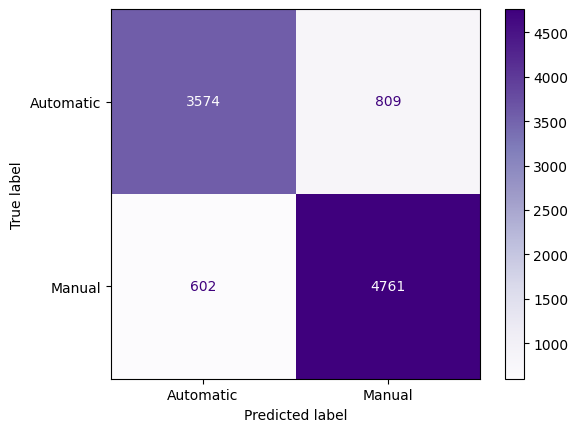

In [ ]:
ConfusionMatrixDisplay.from_estimator(
        pipe_all,
        X_val,
        y_val,
        display_labels=Label.classes_,
         cmap=plt.cm.Purples,

    );

Небольшие выводы по модели:

* категориальные признаки дают прирост качества предсказания (метрика Accuracy на кросс-валидации растет с `0.79` до `0.85`

* добавляется интерпритация некоторых категориальных признаков: некоторые категории "увеличивают" вероятность того что автомобиль - с ручной коробкой, а другие -  вероятность того что автомобиль с автоматической коробкой

# Про то как Сохранять Модель

In [ ]:
from joblib import dump, load # в scikit-learn ничего такого особенного нет
# пользуемся joblib

In [ ]:
dump(model, 'model.joblib')  # чтобы сохранить объект
dump(pipe_num, 'pipe_num.joblib')  # чтобы сохранить объект
dump(pipe_all, 'pipe_all.joblib')  # чтобы сохранить объект

['pipe_all.joblib']

In [ ]:
pipe_load = load('pipe_all.joblib')  # чтобы загрузить из файла в формате joblib

In [ ]:
pipe_load

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('nu...
                                                                   RareGrouper(threshold=0.001)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make']),
                                                 ('cat_model',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.0001)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Model'])])),
                ('model', LogisticRegression(random_state=42))])

# Задания на закрепление

1. Обучите модель на сырых числовых данных без использования предварительной обработки


---


Сравните результат, как с точки зрения метрик, так и с точки зрения весов

In [ ]:
# Место для вашего кода

2. Сделайте изменения в pipeline предварительной обработки
* для числовых признаков можно добавить полиномиальные признаки или использовать другую предварительную обработку
* для категориальных признаков можно использовать целевое кодирование (не забудьте обновить библиотеку scikit-learn)

Обучите модель с новым pipeline предварительной обработки.


---


Сравните результат, как с точки зрения метрик, так и с точки зрения весов


In [ ]:
# Место для вашего кода

3. Вместо класса `LogisticRegression` воспользуйтесь классом `SGDClassifier` в качестве модели

---


Сравните результат, как с точки зрения метрик, так и с точки зрения весов

In [ ]:
# Место для вашего кода

4. (со звездочкой) Воспользуйтесь регуляризацией L1 и сравните результаты

* регуляризация L1 запускается  в рамках классов `SGDClassifier` и `LogisticRegression` (меняется входной параметр `penalty`)

---


Сравните результат, как с точки зрения метрик, так и с точки зрения весов

In [ ]:
# Место для вашего кода

5. (со звездочкой) Используйте в качетсве входных данных добавленные ранее признаки ([Задание 3 и Задание 4 ](https://colab.research.google.com/drive/1vGIHDsCGFvMVQpTZFsc7QFzid5FZzc7N#scrollTo=CTJ1ddP43L_Q) ранее)

---


Сравните результат, как с точки зрения метрик, так и с точки зрения весов

In [ ]:
# Место для вашего кода